## Imports

In [1]:
import pickle
import statistics
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import numpy as np
from src import models
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import model_selection
import keras_tuner
import keras

from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
import scipy.stats as stats



2024-01-29 10:06:35.852501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 10:06:36.390628: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 10:06:36.398431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 10:06:38.694595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%pip install termcolor

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Loading the data

In [3]:
df = pd.read_csv('data/hotmart_ml_test.csv', sep=',', encoding='utf-8')
df = df.set_index('id', drop=True)
df.head(5)

,c1,c2,c3,c4,c5,c6,variant,n1,n2,n3,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
id,,,,,,,,,,,,,,,,,,,,,
0,R0I,YW5kc,ZXM,NaN,True,LTA0OjAw,A,147.175163,508.833307,1.373772,...,198.480790,1.513241e+09,0.877958,563.317119,18.827356,0.111096,0.910215,0.270997,38.999087,0.073268
1,QVI,aW9z,cHQ,aHVhd,True,KzAzOjAw,B,288.359771,1028.901212,13.839420,...,384.252343,7.030908e+08,7.915538,1059.667759,NaN,0.360950,2.965243,0.349473,77.952363,0.185909
2,SVQ,aW9z,ZXM,NaN,True,LTA1OjAw,A,186.063223,650.402814,2.372309,...,249.778061,5.050894e+09,1.573227,700.112963,NaN,0.155331,1.327952,0.140478,49.276629,0.097967
3,R0I,YW5kc,ZXM,NaN,True,LTA0OjAw,A,144.562911,499.384425,0.010756,...,195.028589,2.703625e+09,0.843725,554.100930,NaN,0.108525,0.885378,0.152239,38.323737,0.071742
4,QlI,YW5kc,ZW4,YXBwb,True,NaN,A,77.314738,259.654122,26.709407,...,105.726136,-1.728980e-01,0.274720,313.339044,10.028185,0.054445,0.363698,1.058591,21.585558,0.037120


## Verify missing values

In [4]:
df.isnull().sum() / df.shape[0] * 100

c1          9.892
c2         10.114
c3          0.000
c4         15.110
c5          0.000
c6         10.174
variant     0.000
n1          0.000
n2          0.000
n3          0.000
n4          0.000
n5          0.000
n6          0.000
n7          0.000
n8          0.000
n9         95.486
n10         0.000
n11         0.000
n12         0.000
n13         0.000
n14         0.000
dtype: float64

- Podemos ver claramente que temos alguns valores faltantes nas variáveis que são categóricas do usuário
- Além disso temos a variável `n9` que representa uma feature numérica coletada antes do experimento que também possui valores faltantes
- Vamos verificar se a variavel `n9` é dependente do tipo de experimento que foi feito (como é algo obtido anteriormente não deveria acontecer)

In [5]:
print(f"Vartiant A - n9 missing: {(df[df['variant'] == 'A']['n9'].isnull().sum() / df[df['variant'] == 'A'].shape[0] * 100):.2f}")
print(f"Vartiant B - n9 missing: {(df[df['variant'] == 'B']['n9'].isnull().sum() / df[df['variant'] == 'B'].shape[0] * 100):.2f}")

Vartiant A - n9 missing: 95.45
Vartiant B - n9 missing: 95.58


- Não conseguimos encontrar uma relação entre a variável `n9` e o tipo de experimento como esperado, podemos prosseguir com a análise
- Como temos uma grande porcentagem de valores faltantes e `n9` é uma variável numérica, vamos verificar se ela é significativa para o modelo

In [6]:
df[['n9', 'n14']].dropna().corr('pearson')

,n9,n14
n9,1.000000,0.100089
n14,0.100089,1.000000


In [7]:
df[['n9', 'n14']].dropna().corr('spearman')

,n9,n14
n9,1.0,1.0
n14,1.0,1.0


<Axes: xlabel='n9', ylabel='n14'>

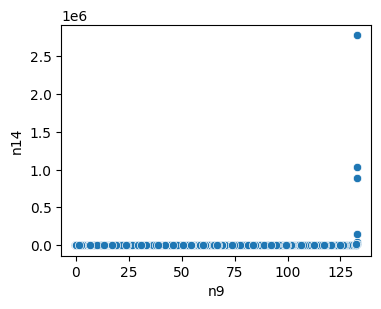

In [8]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x='n9', y='n14', data=df[['n9', 'n14']].dropna())


- A corelação de  pearson de `n9` com a variável target `n14` é baixa
- Na correlação de spearman temos uma correlação alta, mas pode ser por conta de outliers

<Axes: xlabel='variant', ylabel='n14'>

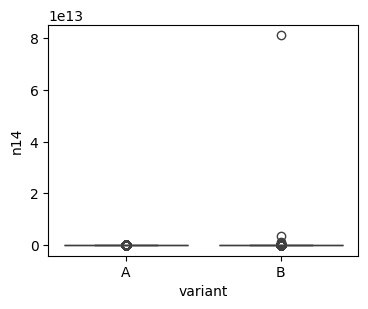

In [9]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='variant', y='n14', data=df)

<Axes: xlabel='variant', ylabel='n14'>

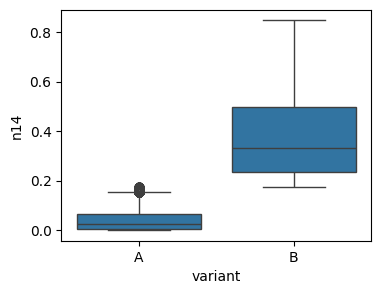

In [10]:
q_max = df['n14'].quantile(0.9)

plt.figure(figsize=(4, 3))
sns.boxplot(x='variant', y='n14', data=df[(df['n14'] < q_max)])

<Axes: xlabel='n9', ylabel='n14'>

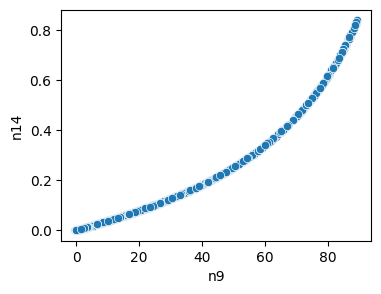

In [11]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x='n9', y='n14', data=df[(df['n14'] < q_max)][['n9', 'n14']].dropna())


- A correlação de spearman de `n9` com a variável target `n14` é perfeira (1), pode ser uma variável muito importante para o modelo ou algo que foi gerado artificialmente a partir da variável target
- Vamos verificar as variaveis categoricas faltantes

In [12]:
target = 'n14'
categoricas = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']

In [13]:
#Numermo de categorias
for col in categoricas:
    print(f"{col}: {df[col].nunique()}")

c1: 174
c2: 4
c3: 29
c4: 268
c5: 2
c6: 35


- Primeiro iremos verificar as variáveis categóricas que possuem poucas categorias

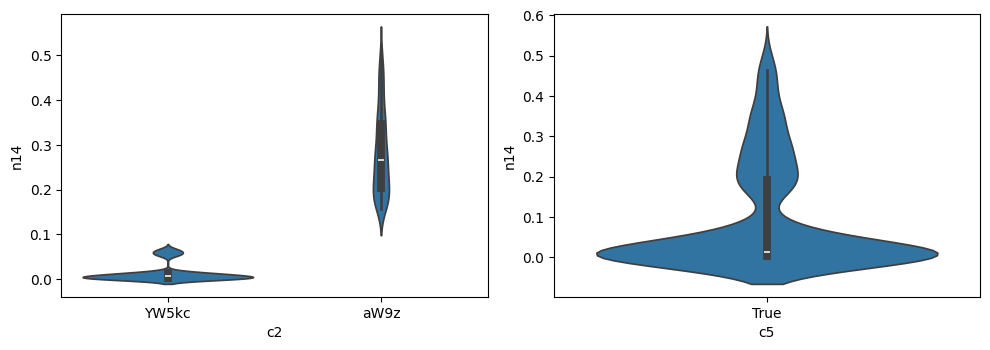

In [14]:
fig = plt.figure(figsize=(10, 10))
for i, col in enumerate(['c2', 'c5']):
    fig.add_subplot(3, 2, i+1)
    sns.violinplot(x=col, y=target, data=df[(df['n14'] < q_max)].dropna())
    fig.tight_layout()

- Podemos perceber que a redulção da imagem de `n14` também representa uma do domínio das variáveis categóricas, ou seja, c5 por exemplo pode representar se o usuário realizou uma compra ou não (caso < `q_min`) ou uma empresa ou comprador em atacado (caso > `q_max`), e como ela não tem valores faltantes podemos considerar uma variável importante para o modelo

In [15]:
print(f"c5 Falso: {df[df['c5'] == False]['n14'].mean():.2f}")
print(f"c5 Verdadeiro: {df[df['c5'] == True]['n14'].mean():.2f}")

c5 Falso: 1993694647981.05
c5 Verdadeiro: 9.28


- Verificando outros valores para c2

In [16]:
_df = df.copy()
_df['c2'] = _df['c2'].fillna('missing')
for variant in _df['c2'].unique():
    print(f"{variant}: {_df[_df['c2'] == variant]['n14'].mean():.2f}")

YW5kc: 0.03
aW9z: 0.23
missing: 1.04
aHRtb: 7.03
d2luZ: 203532633302.15


- Podemos ver que a categoria `d2luZ` é extremamente desbalanceada, vamos verificar a distribuição dela na base

In [17]:
_df = df.copy()
_df['c2'] = _df['c2'].fillna('missing')
for variant in _df['c2'].unique():
    print(f"{variant}: {((_df[_df['c2'] == variant]['n14'].count())/_df.shape[0])*100:.2f}")

YW5kc: 59.96
aW9z: 25.43
missing: 10.11
aHRtb: 3.63
d2luZ: 0.86


- A presença de `d2luZ` na base é muito pequena, podemos usala como uma variável para identificar outliers ou remover ela da base, nesse caso estou buscando deixar a base o mais completa possível, então não irei remove-la, mas irá impactar na escolha de um modelo mais resistente a outliers

- Agora vamos verificar agora as colunas categóricas com muitas categorias

In [18]:
_df['c1'].fillna('NAN', inplace=True)
_df.groupby('c1')[['n14']].mean().sort_values(by='n14', ascending=False)

,n14
c1,
UEc,2.179115e+13
Vkk,1.808045e+11
R0Q,1.131567e+10
Q0Q,3.667998e+09
VEw,1.516742e+08
...,...
VFI,4.237430e-02
QlI,3.407673e-02
NAN,2.258934e-02


In [19]:
_df = df.copy()
_df['c4'].fillna('NAN', inplace=True)
_df.groupby('c4')[['n14']].mean().sort_values(by='n14', ascending=False)

,n14
c4,
YWxpZ,2.179115e+13
bnV1,1.808045e+11
YXhpb,1.131567e+10
YmF1a,3.667998e+09
ZG9yb,1.516742e+08
...,...
eGlhb,2.410788e-01
aHVhd,1.808581e-01
NAN,1.047684e-01


In [20]:
del _df

- Podemos ver que em ambos os casos a média das variáveis NAN é bem a baixo do resto de outros valores, portanto não acredito ser uma boa ideia substituir pela média total
- Agora iremos verificar `c6` que não havia entrado na análise anterior

In [21]:
_df = df.copy()
_df['c6'].fillna('NAN', inplace=True)
_df.groupby('c6')[['n14']].mean().sort_values(by='n14', ascending=False).tail(5)

,n14
c6,
LTA0OjAw,0.065845
NAN,0.039564
ZWdhbF9zdHJp,0.021358
KzA1OjMw,0.009290
KzAyOjAw,0.001950


- Podemos ver novamente que os valores faltantes de `c6` possuem uma média bem abaixo do resto, portanto podemos pensar em algum método como um modelo próprio de classificação para preencher os valores faltantes

#### Resultado da análise de missing values

- c1 & c4 & c6: A categoria de missing está baixo da média na variável target `n14`, usar algum modelo para preencher os valores faltantes 
- c2: A categoria de missing está perto da média, podemos tentar substirtuir pela moda ou usar algum modelo para preencher os valores faltantes
- n9: Tem uma correlação de spearman perfeita com a variável target `n14`, porém existem muitos valores faltantes, podemos tentar usar um modelo poderia enviesar os dados, acredito que poderia ser interessante constuir um modelo para ser utilizado quando possuímos essa variável e outro quando não possuímos, remove-la seria muito custoso para nossa previsão

## EDA - Summary

#### Variáveis quantitativas anteriores ao experimento

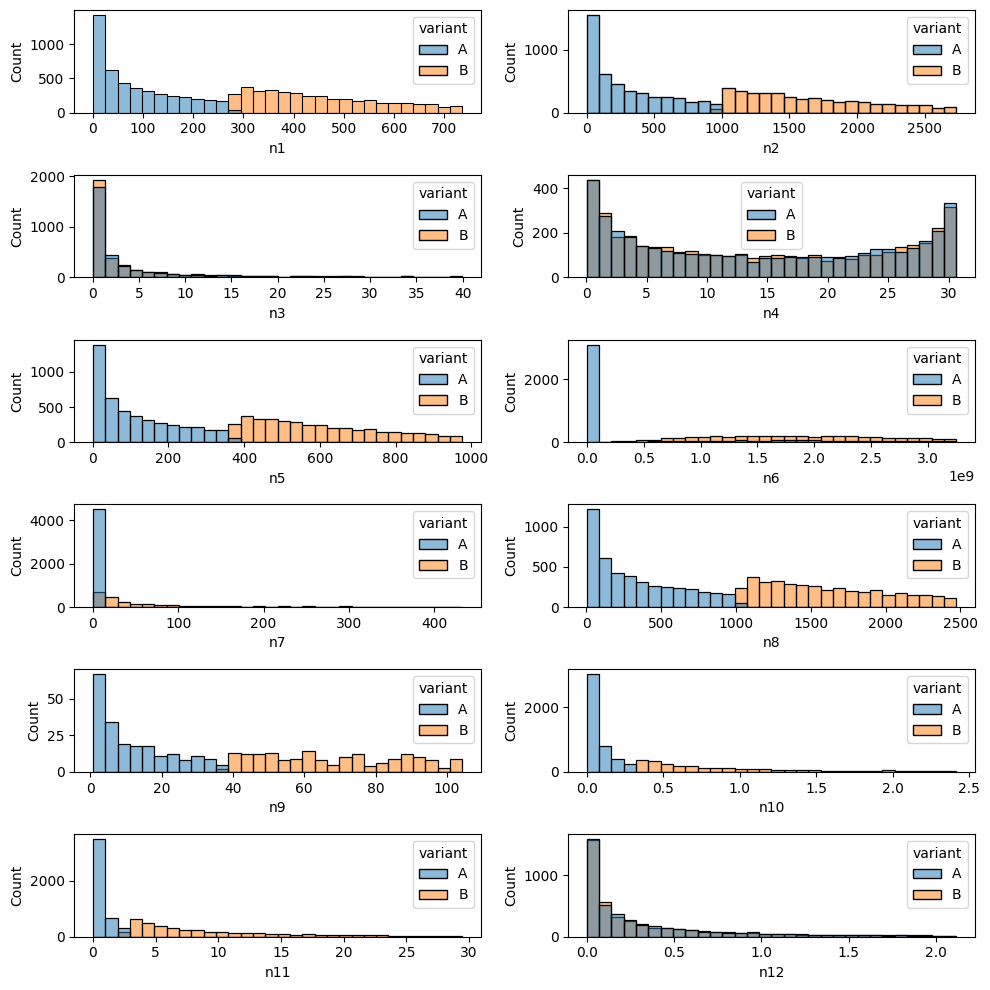

In [22]:
fig = plt.figure(figsize=(10, 10))

variant_a = df[df['variant'] == 'A'].head(5000)
variant_b = df[df['variant'] == 'B'].head(5000)
_df = pd.concat([variant_a, variant_b])

for i, col in enumerate([f'n{n}' for n in range(1,13)]):
    fig.add_subplot(6, 2, i+1)
    if col == 'n3':
        _q_max = 40
    elif col in ['n7', 'n10']:
        _q_max = _df[col].quantile(0.75)
    else:
        _q_max = _df[col].quantile(0.9)
    _q_min = _df[col].quantile(0.05)
    _data = _df[(_df[col] < _q_max) & (_df[col] > _q_min)][[col, 'variant']]
    sns.histplot(x=col, data=_data, hue='variant', bins=30)
    fig.tight_layout()

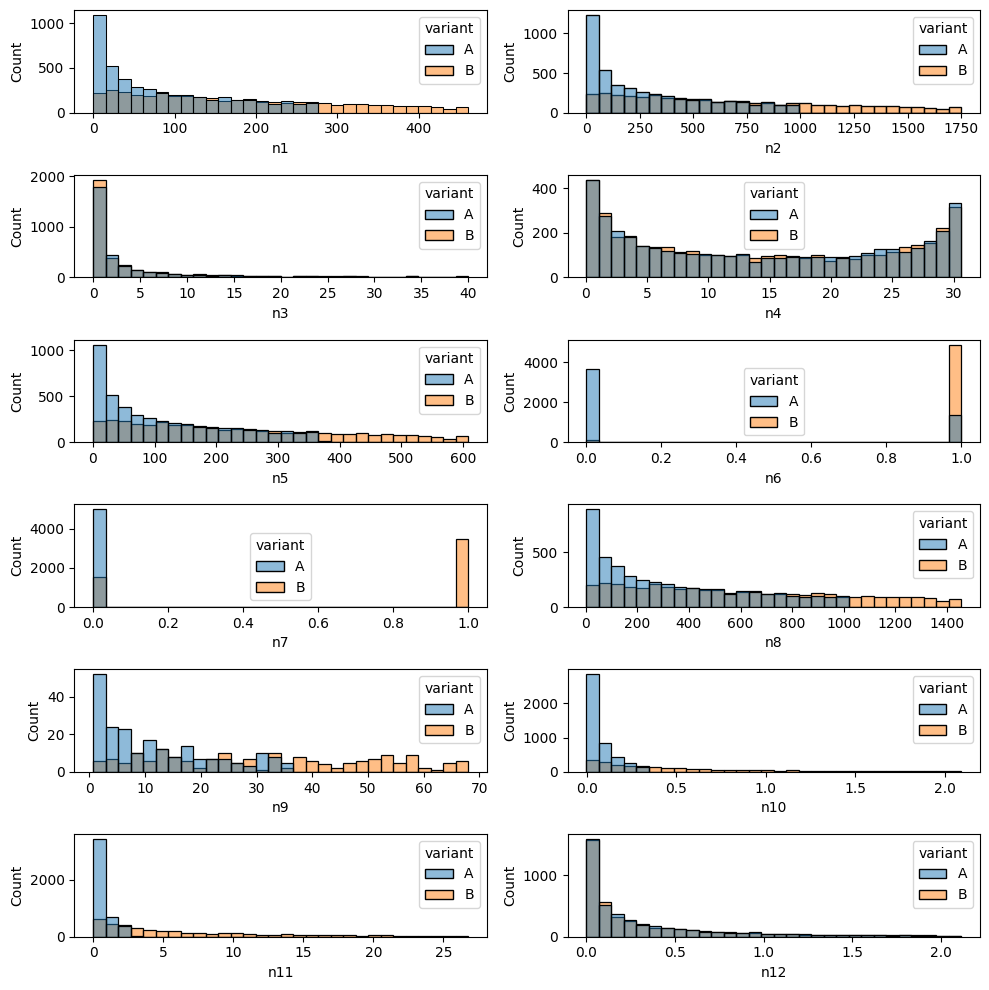

In [23]:
fig = plt.figure(figsize=(10, 10))

variant_a = df[df['variant'] == 'A'].head(5000)
variant_b = df[df['variant'] == 'B'].head(5000)
_df = pd.concat([variant_a, variant_b])

for i, col in enumerate([f'n{n}' for n in range(1,13)]):
    fig.add_subplot(6, 2, i+1)
    if col in ['n1', 'n2', 'n5', 'n8', 'n9', 'n10', 'n11']:
        _df.loc[_df['variant'] == 'B', col] = _df.loc[_df['variant'] == 'B', col] - _df.loc[_df['variant'] == 'A', col].max()
    elif col == 'n9':
        continue
    elif col == 'n6':
        _df[col] = _df[col].apply(lambda x: 1 if x > 0.5 * 1e9 else 0)
    elif col == 'n7':
        _df[col] = _df[col].apply(lambda x: 1 if x > 50 else 0)
    
    _q_min = _df[col].quantile(0.05)
    
    if col == 'n3':
        _q_max = 40
    elif col in ['n10']:
        _q_max = _df[col].quantile(0.75)
    elif col in ['n6', 'n7']:
        _q_max = 2
        _q_min = -2
    else:
        _q_max = _df[col].quantile(0.9)
        
    _data = _df[(_df[col] < _q_max) & (_df[col] > _q_min)][[col, 'variant']]
    sns.histplot(x=col, data=_data, hue='variant', bins=30)
    fig.tight_layout()



### Variáveis categoricas do usuário

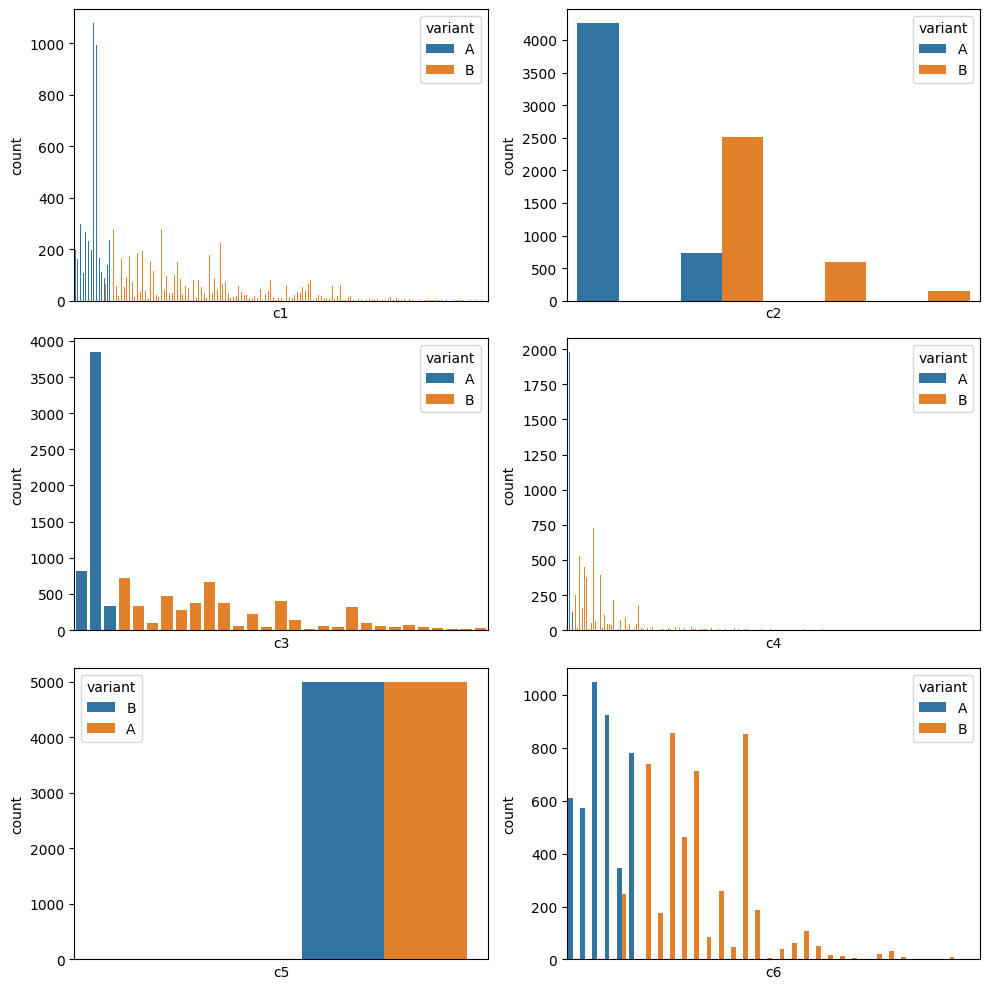

In [24]:
fig = plt.figure(figsize=(10, 10))

variant_a = df[df['variant'] == 'A'].head(5000)
variant_b = df[df['variant'] == 'B'].head(5000)
_df = pd.concat([variant_a, variant_b])

for i, col in enumerate([f'c{n}' for n in range(1,7)]):
    fig.add_subplot(3, 2, i+1)
    sns.countplot(x=col, data=_df, hue='variant')
    plt.xticks([])
    fig.tight_layout()

#### Receita

- Para a parte de EDA, além da variável de revenue `n14` também irei utilizar a variável `n13` de engajamento do usuário durante o teste e uma variável composta de `n13` com `n1` chamada `delta_engajamento` que representa a diferença entre o engajamento do usuário durante o teste e o engajamento do usuário antes do teste
- Começaremos verificando a variável target `n14` como estavamos utilizando anteriormente

In [25]:
df.describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])[['n14']].T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
n14,50000.0,1.754451e+09,3.632668e+11,0.000001,0.000125,0.000988,0.01209,0.055914,0.230044,2.015118,22.399828,8.112489e+13


In [26]:
df.groupby('variant')[['n14']].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

n14                                                            \
           count          mean           std       min        1%        5%   
variant                                                                      
A        35280.0  4.191779e-02  4.452804e-02  0.000001  0.000083  0.000611   
B        14720.0  5.959413e+09  6.695068e+11  0.173297  0.176558  0.190385   

                                                                            
              25%       50%       75%        95%         99%           max  
variant                                                                     
A        0.006444  0.024295  0.065159   0.140432    0.165992  1.732890e-01  
B        0.279915  0.504498  1.234959  11.280494  298.475978  8.112489e+13

<Axes: xlabel='n14', ylabel='Count'>

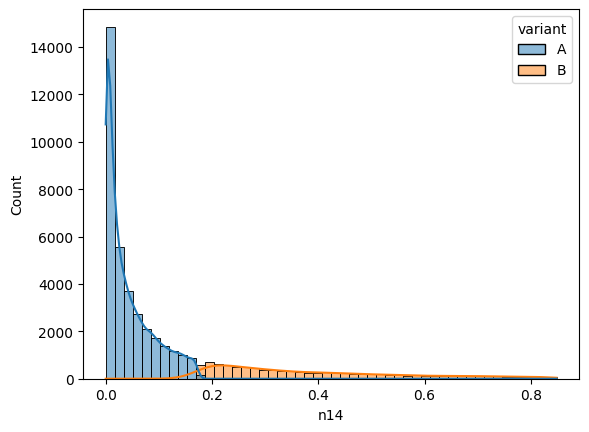

In [27]:
sns.histplot(data=df[(df['n14'] < q_max)], x='n14', hue='variant', bins=50, kde=True)

<Axes: xlabel='n14', ylabel='Count'>

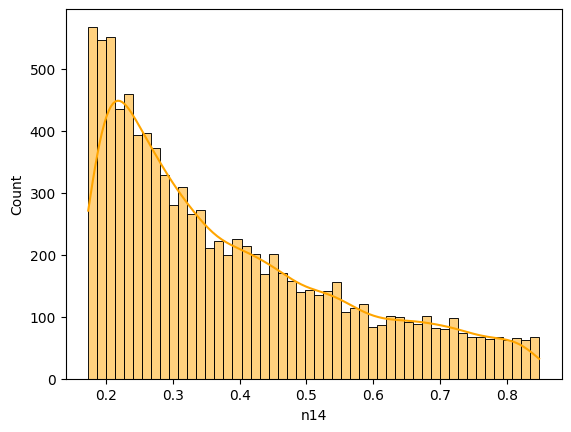

In [28]:
sns.histplot(data=df[(df['n14'] < q_max) & (df['variant'] == 'B')], x='n14', color='orange', bins=50, kde=True)

- Podemos perceber que a variante `B` do teste aumenta a receita do usuário, ainda criando o fenômeno de outliers na receita, isso precisa ser investigado mais a fundo, mas podemos ver que a variante `B` é melhor que a `A` em termos de receita
- Podemos ver que a variante `A` se parece muito com uma função de densidade de probababilidade exponencial, enquanto a variante `B` é como uma função de densidade de probabilidade normal de cauda longa para a direita
- Outra coisa que percebemos é que a variante `A` possui uma maior quantidade de usuários
- Agora vamos verificar a variável `n13` de engajamento do usuário durante o teste

### Engajamento

<Axes: xlabel='n1', ylabel='n13'>

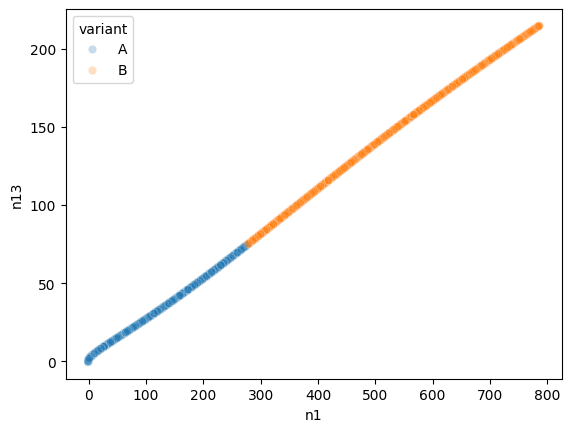

In [29]:
# Comparando o perfil da variável n1 com n13
q_max_n13 = df['n13'].quantile(0.95)
sns.scatterplot(x='n1', y='n13', data=df[df['n13'] < q_max_n13], hue='variant', alpha=0.25)

<Axes: xlabel='n1', ylabel='Count'>

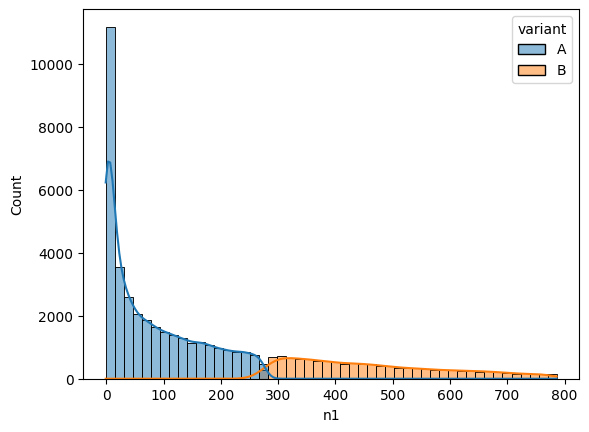

In [30]:
q_max_n1 = df['n1'].quantile(0.95)
sns.histplot(data=df[df['n1'] < q_max_n1], x='n1', hue='variant', bins=50, kde=True)

- Temos um comportamento praticamente linear como esperado, se o usuário teve um engajamento alto antes do teste, ele provavelmente terá um engajamento alto durante o teste, o mesmo vale para um engajamento baixo
- Algo importante de se notar é que a variante `B` foi aplicada em usuários com um engajamento maior que a variante `A` antes do teste, isso pode ser um fator importante para o aumento da receita e pode dar explicações para a diferença de engajamento

In [31]:
df.describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])[['n13']].T
# Valores negativos?

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
n13,50000.0,62.121726,84.047901,-0.383024,-0.083161,0.748439,7.688947,31.016539,89.016613,214.608171,351.389094,2307.458796


In [32]:
df.groupby('variant')[['n13']].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

n13                                                          \
           count        mean        std        min         1%         5%   
variant                                                                    
A        35280.0   21.820021  20.634553  -0.383024  -0.150047   0.435501   
B        14720.0  158.714401  98.749460  74.447050  75.369593  79.156517   

                                                                    \
               25%         50%         75%         95%         99%   
variant                                                              
A         4.318829   14.656728   35.352569   64.447703   72.337286   
B        99.691058  133.410302  185.994554  313.205385  491.741872   

                      
                 max  
variant               
A          74.444739  
B        2307.458796

<Axes: xlabel='n13', ylabel='Count'>

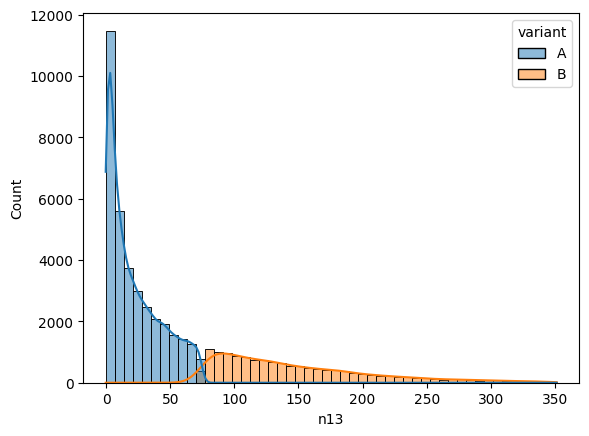

In [33]:
q_max_n13 = df['n13'].quantile(0.99)
sns.histplot(data=df[df['n13'] < q_max_n13], x='n13', hue='variant', bins=50, kde=True)

- Novamente temos o mesmo comportamento quanto a distribuição
- Agora vamos verificar a variável `delta_engajamento` que representa a diferença entre o engajamento do usuário durante o teste e o engajamento do usuário antes do teste

In [34]:
df['delta_engajamento'] = df['n13'] - df['n1']
df[['delta_engajamento']].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
delta_engajamento,50000.0,-165.4572,240.205464,-6840.381211,-1014.827541,-571.358858,-237.477895,-84.786111,-12.069519,1.207743,1.358492,1.365066


<Axes: xlabel='delta_engajamento', ylabel='Count'>

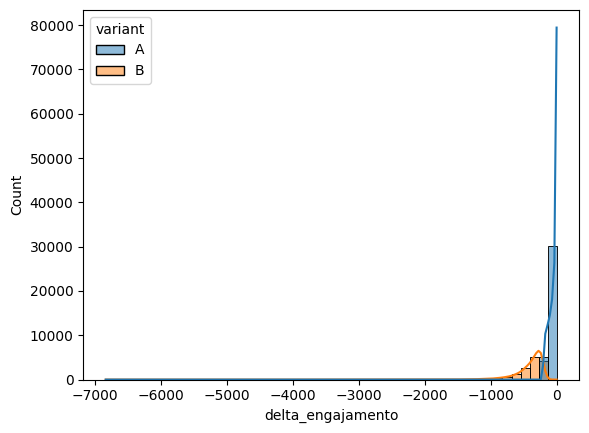

In [35]:
sns.histplot(data=df, x='delta_engajamento', hue='variant', bins=50, kde=True)

<Axes: xlabel='delta_engajamento', ylabel='Count'>

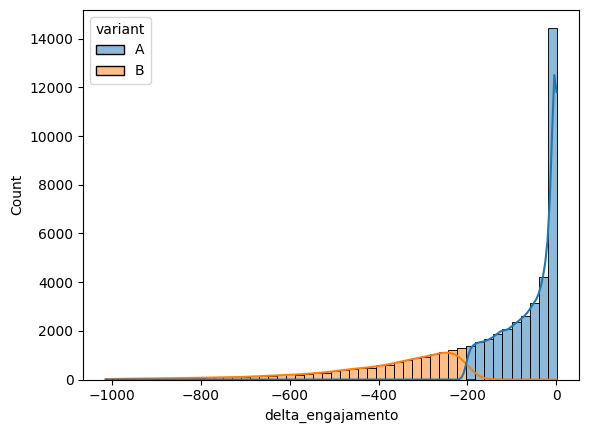

In [36]:
q_min_delta = df['delta_engajamento'].quantile(0.01)
sns.histplot(data=df[df['delta_engajamento'] > q_min_delta], x='delta_engajamento', hue='variant', bins=50, kde=True)

<Axes: xlabel='delta_engajamento', ylabel='Count'>

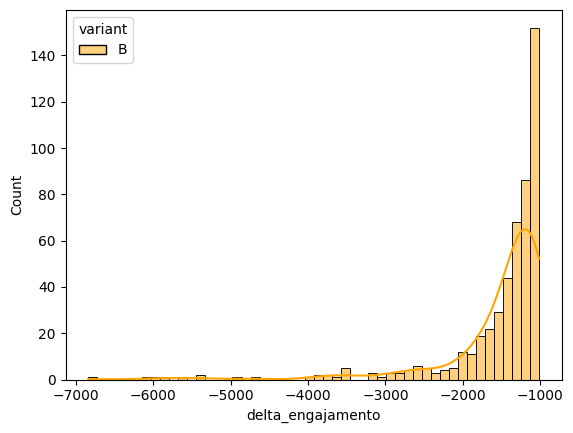

In [37]:
sns.histplot(data=df[df['delta_engajamento'] < q_min_delta], x='delta_engajamento', hue='variant',
             palette= {"A":"blue", "B":"orange"}, bins=50, kde=True)

In [38]:
del df['delta_engajamento']

- Aqui já temos um comportamento diferente do esperado, a variante `B` possuí uma calda longa para a esquerda, o que pode indicar que diminuiu consideravelmente o engajamento de alguns heavy users, enquanto a variante `A` está mais próxima do esperado

## Resultado - Escolha de uma variante

Com os dados de EDA podemos ver que a variante `B` é melhor que a variante `A` em termos de receita, porém a variante `B` possui uma calda longa para a esquerda na variável `delta_engajamento` que representa a diferença entre o engajamento do usuário durante o teste e o engajamento do usuário antes do teste, isso pode indicar que a variante `B` diminuiu consideravelmente o engajamento de alguns heavy users, enquanto a variante `A` está mais próxima do esperado.

Portanto a escolha de uma das variantes seria dependente da estratégia da empresa, se a empresa quiser aumentar a receita a variante `B` seria a melhor escolha, porém se a empresa quiser manter o engajamento dos usuários a variante `A` seria a melhor escolha no caso de ser necessário escolher uma das variantes.

Porém, para apresentar uma resposta sólida, indicaria a empresa a escolher a variante `B` pela grande diferença de receita e por ser um pouco mais balanceada do que a variante `A`, mas também indicaria que a empresa deveria investigar o motivo da diminuição do engajamento de alguns heavy users, pois isso pode ser um problema no futuro. Ou, em segundo caso, testar mais variações para ver se é possível aumentar a receita sem afetar tanto engajamento.

## Data Preparation

In [39]:
df_prep = df.copy()

#Missing Data
df_prep = df_prep.drop('n9', axis=1)


In [40]:
# Outliers in output
q_min_n13 = df_prep['n13'].quantile(0.05)
q_max_n13 = df_prep['n13'].quantile(0.9)
df_prep = df_prep[(df_prep['n13'] > q_min_n13) & (df_prep['n13'] < q_max_n13)]

q_min_n14 = df_prep['n14'].quantile(0.05)
q_max_n14 = df_prep['n14'].quantile(0.9)
df_prep = df_prep[(df_prep['n14'] > q_min_n14) & (df_prep['n14'] < q_max_n14)]



In [41]:
# Outliers in X variables
for i, col in enumerate([f'n{n}' for n in range(1,13)]):

    if col in ['n1', 'n2', 'n5', 'n8', 'n9', 'n10', 'n11']:
        _df.loc[_df['variant'] == 'B', col] = _df.loc[_df['variant'] == 'B', col] - _df.loc[_df['variant'] == 'A', col].max()
    elif col == 'n9':
        continue
    elif col == 'n6':
        _df[col] = _df[col].apply(lambda x: 1 if x > 0.5 * 1e9 else 0)
    elif col == 'n7':
        _df[col] = _df[col].apply(lambda x: 1 if x > 50 else 0)

    if col == 'n3':
        _q_max = 40
    elif col in ['n7', 'n10']:
        _q_max = df_prep[col].quantile(0.75)
    elif col == 'n9':
        continue
    else:
        _q_max = df_prep[col].quantile(0.98)
    _q_min = df_prep[col].quantile(0.05)
    df_prep = df_prep[(df_prep[col] < _q_max) & (df_prep[col] > _q_min)]

### Feature Engineering

Achei muito necessário substiruir os valores de n13(como variavel objetivo) pela diferença entre o engajamento durante o teste e o engajamento antes do teste, pois acredito que o impácto do teste no engajamento seja o que realmente estamos medindo

In [42]:
df['n13'] = df['n13'] - df['n1']

In [43]:
#One Hot Encoding
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc.fit(df_prep[['c1', 'c2', 'c3', 'c4', 'c5', 'c6']])

categorical_columns = df_prep[['c1', 'c2', 'c3', 'c4', 'c5', 'c6']]
categorical_columns = enc.transform(categorical_columns)
categorical_columns = pd.DataFrame(categorical_columns, columns=enc.get_feature_names_out())
df_prep = pd.concat([df_prep, categorical_columns], axis=1)
df_prep = df_prep.drop(['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], axis=1)

normalizer = {}
#Normalização
for col in ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8','n10', 'n11', 'n12', 'n13', 'n14']:
    normalizer[col] = {'min': df_prep[col].min(), 'max': df_prep[col].max(), 'mean' : df_prep[col].mean()}
    df_prep[col] = (df_prep[col] - df_prep[col].min()) / (df_prep[col].max() - df_prep[col].min())

df_prep = df_prep.dropna(axis=0)
df_prep.head(5)

,variant,n1,n2,n3,n4,n5,n6,n7,n8,n10,...,c1_VFI,c1_VVM,c1_nan,c2_YW5kc,c3_ZW4,c4_YXBwb,c5_True,c6_LTA0OjAw,c6_ZWdhbF9zdHJp,c6_nan
4,A,0.474378,0.464957,0.668035,0.872008,0.477812,4.421847e-11,0.310531,0.490120,0.421924,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,A,0.534866,0.525724,0.058496,0.093949,0.538184,2.851189e-11,0.366568,0.549846,0.480179,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
22,A,0.645367,0.637344,0.019908,0.782177,0.648253,1.609247e-10,0.481854,0.658050,0.591251,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
28,A,0.964346,0.963274,0.017457,0.998549,0.964721,3.179785e-01,0.935209,0.965875,0.954629,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
32,A,0.619969,0.611622,0.133910,0.002677,0.622977,2.620047e-10,0.453771,0.633272,0.565153,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [44]:
X = df_prep.drop(['n13', 'n14'], axis=1)
X.loc[:,'variant'] = X['variant'].map({'A': 0, 'B': 1})
X = X.values.astype('float32')
y = df_prep[['n13', 'n14']].values.astype('float32')

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### Salvando as informações sobre os dados e encoder

In [45]:
with open('utils/encoder.pkl', 'wb') as f:
    pickle.dump(enc, f)

with open('utils/columns.pkl', 'wb') as f:
    pickle.dump(['c1', 'c2', 'c3', 'c4', 'c5', 'c6',
                 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9','n10', 'n11', 'n12'], f)

with open('utils/normalizer.pkl', 'wb') as f:
    pickle.dump(normalizer, f)

## Modelo de Predição de Receita + Engajamento

In [88]:
input_shape = (X_train.shape[1],)
reg_tuner = keras_tuner.tuners.BayesianOptimization(
    hypermodel=models.m_build_model_regression(input_shape),
    objective = keras_tuner.Objective("val_mae", "min"),
    max_trials = 25,
    seed = 42,
    directory = 'reg_tuner',
    project_name = 'hotmart_ml_test')

In [89]:
reg_tuner.search(X_train, y_train,
                epochs=5, 
                validation_split=0.2)

Trial 25 Complete [00h 00m 02s]
val_mae: 0.06640397757291794

Best val_mae So Far: 0.023490093648433685
Total elapsed time: 00h 01m 32s


In [90]:
best_model_keras = reg_tuner.get_best_models(num_models=1)[0]
best_model_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1664      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3810 (14.88 KB)
Trainable params: 3810 (14.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
sklearn_tuner_reg = keras_tuner.tuners.SklearnTuner(
    oracle = keras_tuner.oracles.BayesianOptimizationOracle(
        objective = keras_tuner.Objective("score", "max"),
        max_trials = 25,
        seed = 42),
    hypermodel = models.build_model_sklearn_regression,
    scoring = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False),
    cv = model_selection.KFold(n_splits=5),
    directory = 'sklearn_tuner_reg',
    project_name = 'hotmart_ml_test')


In [92]:
sklearn_tuner_reg.search(X_train, y_train)

Trial 25 Complete [00h 00m 00s]
score: -0.03564014732837677

Best score So Far: -4.424477720021969e-06
Total elapsed time: 00h 00m 07s


In [51]:
best_model_sklearn = sklearn_tuner_reg.get_best_models(num_models=1)[0]
print(f"Melhor modelo Sklearn: {best_model_sklearn}")


Melhor modelo Sklearn: MultiOutputRegressor(estimator=LinearRegression())


In [52]:
if reg_tuner.oracle.get_best_trials()[0].score < sklearn_tuner_reg.oracle.get_best_trials()[0].score:
    print(colored(f"Melhor modelo escolhido como Keras", 'red'))
    best_model = best_model_keras
    model_src = 'keras'
else:
    print(colored(f"Melhor modelo escolhido como Sklearn", 'red'))
    best_model = best_model_sklearn
    model_src = 'sklearn'

with open(f'utils/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

best_model = best_model_keras
model_src = 'keras'

Melhor modelo escolhido como Sklearn


## Escolhendo uma variante para o usuário

In [53]:
## Simulando um request
possible_user_data = df.copy()
possible_user_data = possible_user_data.drop(['n13', 'n14', 'variant'], axis=1)

user_data_sent = possible_user_data.loc[0,:].values

Primeiramente recebemos do usuário as variáveis de `n1` a `n12` e `c1` a `c6` e com isso iremos prever a variável `n14` e `n13` para cada variante do teste, após isso iremos escolher a variante que maximiza a receita e o engajamento do usuário

In [60]:

encoder = pickle.load(open('utils/encoder.pkl', 'rb'))
model = pickle.load(open('utils/best_model.pkl', 'rb'))
columns = pickle.load(open('utils/columns.pkl', 'rb'))
normalizer = pickle.load(open('utils/normalizer.pkl', 'rb'))

def normalize(col, x):
    return (x - normalizer[col]['min']) / (normalizer[col]['max'] - normalizer[col]['min'])

def prepare_user_data(user_data_recieved):

    user_data = pd.DataFrame(user_data_recieved.reshape(1, -1), columns=columns)
    user_data = user_data.drop(['n9'], axis=1)

    user_data_categorical = user_data[['c1', 'c2', 'c3', 'c4', 'c5', 'c6']]
    user_data_categorical = encoder.transform(user_data_categorical)
    user_data_categorical = pd.DataFrame(user_data_categorical, columns=encoder.get_feature_names_out())

    user_data = user_data.drop(['c1', 'c2', 'c3', 'c4', 'c5', 'c6'], axis=1)
    user_data = pd.concat([user_data, user_data_categorical], axis=1)

    for col in ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8','n10', 'n11', 'n12']:
        if col in ['n1', 'n2', 'n5', 'n8', 'n9', 'n10', 'n11']:
            _df.loc[_df['variant'] == 'B', col] = _df.loc[_df['variant'] == 'B', col] - normalizer[col]['max']
        elif col == 'n9':
            continue
        elif col == 'n6':
            _df[col] = _df[col].apply(lambda x: 1 if x > 0.5 * 1e9 else 0)
        elif col == 'n7':
            _df[col] = _df[col].apply(lambda x: 1 if x > 50 else 0)
        user_data[col] = normalize(col, user_data[col])

    user_data.loc[1,:] = user_data.loc[0,:]

    user_data.loc[0,'variant'] = 0
    user_data.loc[1,'variant'] = 1

    return user_data.values.astype('float32')


def normalize_result(x, pesos):
    return ((x * [normalizer['n13']['max'], normalizer['n14']['max']]) / [normalizer['n13']['mean'], normalizer['n14']['mean']]) * pesos

def predict(user_data, pesos):
    user_data = prepare_user_data(user_data)
    result = model.predict(user_data)
    
    if normalize_result(result[0], pesos).sum() >= normalize_result(result[1], pesos).sum():
        return 'A'
    else:
        return 'B'

In [86]:
wheigts_search_space = 20
search_data = pd.DataFrame(columns=['peso_n13', 'peso_n14', 'win'])

for a in np.linspace(-10, wheigts_search_space, 25):
    for b in np.linspace(-10, wheigts_search_space, 25):
        vc = possible_user_data.head(10).apply(lambda x : predict(x.values, [a,b]), axis=1).value_counts()
        search_data.loc[len(search_data), :] = [a, b, vc.idxmax()]

<Axes: xlabel='peso_n13', ylabel='peso_n14'>

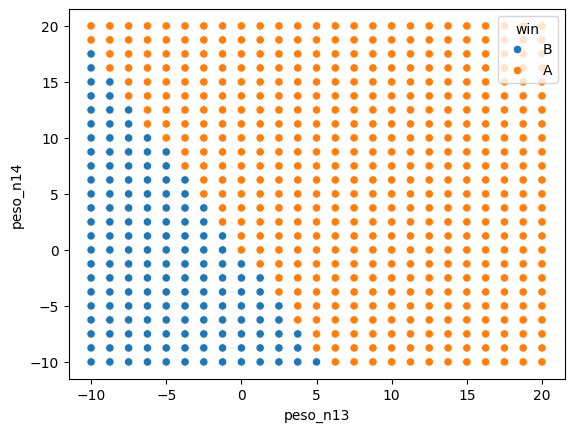

In [87]:
sns.scatterplot(x='peso_n13', y='peso_n14', data=search_data, hue='win')

## Resultado - Modelo de recomendação

O modelo de recomendação criado consiste de um modelo de regressão para prever a variável `n14` e `n13` para cada variante do teste, após isso iremos escolher a variante que maximiza a receita e o engajamento do usuário, para isso, podemos utilizar uma conjuntos de peso 1,1 que mostra que nos importamos tanto com a receita quanto com o engajamento do usuário, ou podemos utilizar um conjunto de pesos mais alinhado a realidade do negócio.

O gráfico acima mostra a prevalência de um dos tipos de variante a cada conjunto de pesos escolhido, podemos ver assim que a variante A irá favorecer mais a variável `n13` correspondente ao engajamento, enquanto a variante B irá favorecer mais a variável `n14` correspondente a receita.
